<a href="https://colab.research.google.com/github/gerardPlanella/DeepLearning1_UvA_22/blob/main/assignment2/assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning 1, Assignment 2: Transfer Learning for CNNs, Visual Prompting, Graph Neural Networks

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import CIFAR100
from torch.utils.data.dataloader import DataLoader
import torchvision.transforms as tt
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
#Import Models to evaluate
from torchvision.models import vgg11, vgg11_bn, resnet18, resnet34, densenet121, mobilenet_v3_small
from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np
import time
from copy import deepcopy
import gc

%matplotlib inline

We will set the seeds and detect the GPU used.

In [8]:
seed = 42
# Set the random seeds for reproducibility
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():  # GPU operation have separate seed
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.determinstic = True
    torch.backends.cudnn.benchmark = False

# Set default device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if(torch.cuda.is_available()):
    print("Using GPU: " + torch.cuda.get_device_name(device))
else:
    print("Using CPU")

Using GPU: Tesla T4


## Part 1: Transfer Learning for CNNs

### 1a: Model Comparison

We will compare the models VGG11, VGG11 with Batch Normalization, ResNet18, ResNet34, DenseNet121 and MobileNet-v3-Small using the Top-1 accuracy on Image Net. The models used are pre-trained from PyTorch.

In [ ]:
N_IMAGES = 10
IMAGE_DIM = 256
DATASET = "IMAGENET1K_V1"
fake_image = torch.rand(1, 3, IMAGE_DIM, IMAGE_DIM, dtype=torch.float)

model_info = {
    "VGG11": {"top1acc": 69.02, "n_params": 132863336, "inference_time_noGrad": None, "inference_time": None},
    "VGG11_BN": {"top1acc": 70.37, "n_params": 132863336, "inference_time_noGrad": None, "inference_time": None},
    "ResNet18": {"top1acc": 69.758, "n_params" : 11689512, "inference_time_noGrad": None, "inference_time": None},
    "ResNet34": {"top1acc": 73.314, "n_params": 21797672, "inference_time_noGrad": None, "inference_time": None},
    "DenseNet121": {"top1acc": 74.434, "n_params": 7978856, "inference_time_noGrad": None, "inference_time": None},
    "MobileNetV3_Small": {"top1acc": 67.668, "n_params": 2542856, "inference_time_noGrad": None, "inference_time": None}
}

models = {
    "VGG11": vgg11(weights=DATASET),
    "VGG11_BN":vgg11_bn(weights=DATASET),
    "ResNet18": resnet18(weights=DATASET),
    "ResNet34": resnet34(weights=DATASET),
    "DenseNet121": densenet121(weights=DATASET),
    "MobileNetV3_Small": mobilenet_v3_small(weights=DATASET)
}


Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

Firstly, we evaluate the inference times for all the models with and without the torch.no_grad() parameter. We will process 50 images and average the inference time for each model.

In [ ]:
def get_inference_time(model, device, image, repetitions, no_grad = True):
    model.eval()
    model.to(device)
    image = image.to(device)
    times = np.zeros((repetitions, 1))
    start, end = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

    #GPU Warmup
    for i in range(20):
        _ = model(image)
    
    if no_grad:
        with torch.no_grad():
            for i in range(repetitions):
                start.record()
                _ = model(image)
                end.record()
                torch.cuda.synchronize()
                times[i] = start.elapsed_time(end)
    else:
        for i in range(repetitions):
            start.record()
            _ = model(image)
            end.record()
            torch.cuda.synchronize()
            times[i] = start.elapsed_time(end)

    
    time = np.sum(times) / repetitions
    model.cpu()
    image = image.cpu().detach()
    return time

N_REPETITONS = 50

for model_name in models.keys():
    model_info[model_name]["inference_time_noGrad"] = get_inference_time(models[model_name], device, fake_image, N_REPETITONS)
for model_name in models.keys():
    model_info[model_name]["inference_time"] = get_inference_time(models[model_name], device, fake_image, N_REPETITONS, no_grad=False)


We will now plot the results for the different models.

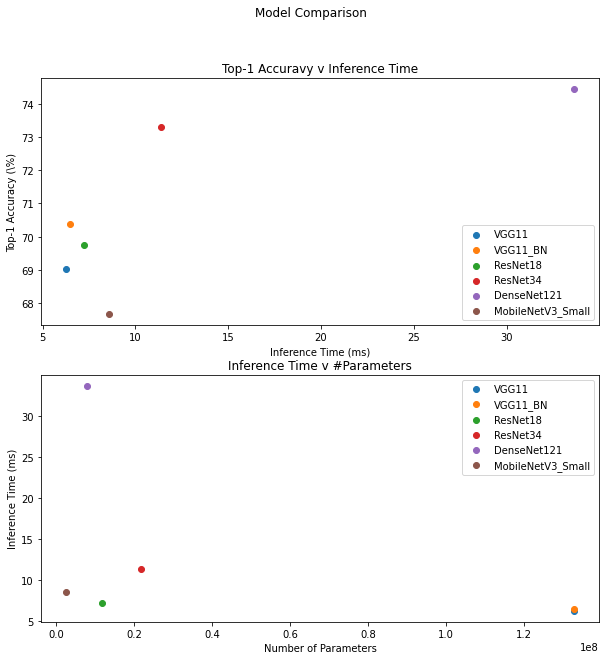

In [ ]:
def plot_model_info(model_info, x_axis_key, x_axs_label, y_axis_key, y_axis_label, title, ax):
    x = [model_info[name][x_axis_key] for name in model_info.keys()]
    x_keys = [name for name in model_info.keys()]

    y_no_grad = [model_info[name][y_axis_key] for name in x_keys]

    for x_val, x_label, y in zip(x, x_keys, y_no_grad):
        ax.scatter(x_val, y, label=x_label)

    ax.set_title(title)
    ax.set_xlabel(x_axs_label)
    ax.set_ylabel(y_axis_label)
    ax.legend()


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))

fig.suptitle("Model Comparison")

plot_model_info(model_info, "inference_time_noGrad", "Inference Time (ms)", "top1acc", "Top-1 Accuracy (\%)", "Top-1 Accuravy v Inference Time", ax1)
plot_model_info(model_info, "n_params", "Number of Parameters", "inference_time_noGrad", "Inference Time (ms)", "Inference Time v #Parameters", ax2)

plt.show()


What we can observe from these plots is that as the number of parameters increases, so does the inference time, which is to be expected. Nevertheless, this is not the case for DenseNet121. This relationship between inference time and # of parameters will be highly dependent on the network architecture.

In addition, we can also observe that Models with a higher Inference Time normally have a higher Top-1 Accuracy, which makes sense as the models with higher inference speeds will normally be more complex.

### 1b. Impact of torch.no_grad() on inference speed

We will now evaluate the effect that using torch.no_grad()has on our inference time.

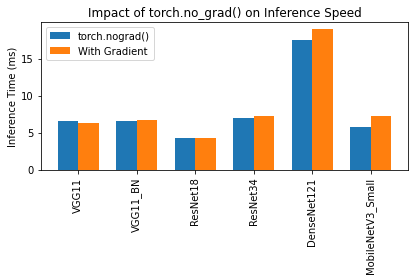

In [ ]:
def plot_torch_nograd_inference(model_info, ax):
    x_keys = [name for name in model_info.keys()]

    y_no_grad = [model_info[name]["inference_time_noGrad"] for name in x_keys]
    y_grad = [model_info[name]["inference_time"] for name in x_keys]

    width = 0.35
    x = np.arange(len(x_keys))
    rects1 = ax.bar(x - width/2, y_no_grad, width, label="torch.nograd()")
    rects2 = ax.bar(x + width/2, y_grad, width, label="With Gradient")


    ax.set_title("Impact of torch.no_grad() on Inference Speed")
    #ax.set_xticks(x, x_keys)
    ax.set_xticks(x) # values
    ax.set_xticklabels(x_keys) 
    ax.set_ylabel("Inference Time (ms)")
    ax.legend()

    #ax.bar_label(rects1, padding=3)
    #ax.bar_label(rects2, padding=3, label_type="center")
    
fig, ax = plt.subplots()
plot_torch_nograd_inference(model_info, ax)
plt.xticks(rotation=90)
fig.tight_layout()
plt.show()

We can see that using torch.no_grad() decreases our inference time. This is to be expected as when computing the forward pass, the no_grad flag will prevent the gpu from saving the outputs that would be used to calculate the backward pass. The time difference we see is given by the time needed to save to memory all of these intermediate values.

### 1c. GPU vRAM Usage with torch.no_grad()

---



This part will analyse the effect that torch.no_grad() has on the GPU vRAM usage in our forward passes. 

In [ ]:
def evaluate_memory_allocation(model, device, no_grad = True, image_dim = IMAGE_DIM):    
    mem = None
    model.eval()
    model.to(device)
    fake_batch = torch.rand(64, 3, image_dim, image_dim, dtype=torch.float)
    fake_batch = fake_batch.to(device)

    if no_grad:
        with torch.no_grad():
            mem_start = torch.cuda.memory_allocated()
            out = model(fake_batch)
            mem_end = torch.cuda.memory_allocated()
            mem = (mem_end - mem_start)/1000000
            
    else:
        mem_start = torch.cuda.memory_allocated()
        out = model(fake_batch)
        mem_end = torch.cuda.memory_allocated()
        mem = (mem_end - mem_start)/1000000
    
    del out
    model.cpu()
    fake_batch = fake_batch.cpu().detach()
    del fake_batch

    return mem
 

for model_name in models.keys():
    model_info[model_name]["memory_allocated_noGrad"] = evaluate_memory_allocation(models[model_name], device)
    model_info[model_name]["memory_allocated"] = evaluate_memory_allocation(models[model_name], device, no_grad=False)
    

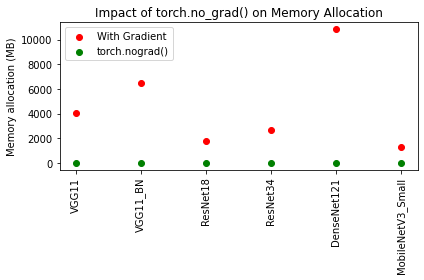

In [ ]:
def plot_torch_nograd_memory(model_info, ax):
    x_keys = [name for name in model_info.keys()]

    y_no_grad = [model_info[name]["memory_allocated_noGrad"] for name in x_keys]
    y_grad = [model_info[name]["memory_allocated"] for name in x_keys]

    x = np.arange(len(x_keys))



    ax.scatter(x, y_grad, label = "With Gradient", color="red")
    ax.scatter(x, y_no_grad, label = "torch.nograd()", color = "green")

    ax.set_title("Impact of torch.no_grad() on Memory Allocation")
    ax.set_xticks(x) # values
    ax.set_xticklabels(x_keys) 
    ax.set_ylabel("Memory allocation (MB)")
    ax.legend()


    
fig, ax = plt.subplots()
plot_torch_nograd_memory(model_info, ax)
plt.xticks(rotation=90)
fig.tight_layout()
plt.show()

We can observe how the amount of GPU vRAM used with torch.no_grad() negligible compared to not using this method. Similarly to the inference time, when we use torch.no_grad() the intermediate values that would be used to calculate a backward pass are not stored, which is reflected on the memory allocation during the forward passes. We can also see that the models with more parameters are the ones that benefit the most from the use of torch.no_grad.

We will now delete the loaded models to lessen our RAM usage

In [ ]:
for model in models:
  del model
  model = None

gc.collect()
torch.cuda.empty_cache()

### 2a. ResNet-18 Transfer Learning on CIFAR-100



We will begin by loading the CIFAR-100 dataset and preparing the datasets.

In [53]:
batch_size = 32
epochs = 10
lr = 0.001
momentum = 0.9
validation_split = 0.1

In [54]:
def getCIFAR100():
  train_data = CIFAR100(root="./data", download=True, train = True)
  test_data = CIFAR100(root="./data",download = True,train=False)

  x = np.concatenate([np.asarray(train_data[i][0]) for i in range(len(train_data))])

  mean = np.mean(x, axis=(0, 1))/255
  std = np.std(x, axis=(0, 1))/255

  mean=mean.tolist()
  std=std.tolist()

  print(f"CIFAR-100 Mean: " + str(mean))
  print(f"CIFAR-100 Std: " + str(std))

  data_transform = tt.Compose([
      tt.ToTensor(),
      tt.Normalize(mean, std)
  ])

  #Obtain DataSets
  train_data = CIFAR100(root="./data", download=True, train = True, transform=data_transform)
  test_data = CIFAR100(root="./data",download = True, train=False, transform =data_transform)

  #Obtain Validation Set
  dataset_split = [int(len(train_data) * (1-validation_split)), int(len(train_data) * (validation_split))]
  train_data, validation_data = torch.utils.data.dataset.random_split(train_data, dataset_split, generator=torch.Generator().manual_seed(seed))

  print(len(validation_data))
  print(len(train_data))

  trainLoader = torch.utils.data.DataLoader(
      train_data, batch_size, shuffle=True, drop_last = True)

  testLoader = torch.utils.data.DataLoader(
      test_data, batch_size, shuffle=True, drop_last = False)


  valLoader = torch.utils.data.DataLoader(
      validation_data, batch_size, shuffle=True, drop_last = False)

  dataLoaders = {
      "train":trainLoader,
      "val":valLoader,
      "test":testLoader
  }

  n_classes = len(test_data.classes)
  return dataLoaders, n_classes

dataLoaders, n_classes = getCIFAR100()

Files already downloaded and verified
Files already downloaded and verified
CIFAR-100 Mean: [0.5070751592371323, 0.48654887331495095, 0.4409178433670343]
CIFAR-100 Std: [0.26733428587941854, 0.25643846292120615, 0.2761504713263903]
Files already downloaded and verified
Files already downloaded and verified
5000
45000


We will now initialize the model and visualize the layers.

In [55]:
model = resnet18(weights="IMAGENET1K_V1")
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

We can see the fully connected layer with 1000 output features, we will change this layer to suit out dataset.

In [56]:
fc_features_in = model.fc.in_features
fc_features_out = n_classes


for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(fc_features_in, fc_features_out)
model.fc.weight = nn.init.normal_(model.fc.weight, mean=0.0, std=0.01)    
model.fc.bias = nn.init.zeros_(model.fc.bias)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

With our model now defined, we will implement our training function and testing function.

In [57]:
def train_model(model, data, criterion, optimizer, device, num_epochs = epochs):
  best_model_state_dict = None
  best_acc = 0
  losses = []
  acc = []

  for epoch in tqdm(range(num_epochs)):
    model, loss = train_step_model(device, model, criterion, optimizer, data["train"])
    losses += [loss]


    accuracy = evaluate_model(model, data["val"], device)
    acc += [accuracy]

    print(f" Loss: {loss}, Accuracy: {accuracy}")

    if(accuracy > best_acc):
      best_acc = accuracy
      best_model_state_dict = deepcopy(model.state_dict())
    
  model.load_state_dict(best_model_state_dict)

  return model, losses, acc

def train_step_model(device, model, criterion, optimizer, data):
  losses = []

  model.train()
  for x, t in data:
    x = x.to(device)
    t = t.to(device)

    optimizer.zero_grad()
    
    preds = model(x)

    loss = criterion(preds, t)
    losses.append(loss.cpu().detach().numpy())

    loss.backward()
    optimizer.step()

  return model, np.mean(losses)

def evaluate_model(model, data, device):
  model.eval()
  acc = 0

  with torch.no_grad():
    for x, t in data:
      x = x.to(device)
      t = t.to(device)
      out = model(x)
      
      out = out.cpu().detach().numpy()
      preds = np.argmax(out, axis = 1)

      acc += np.sum(t.cpu().numpy() == preds)

      

  return (acc / len(data.dataset)) * 100


    

With the training and testing routines implemented, we can now finetune our modified ResNet18 on the CIFAR-100 dataset.

 10%|█         | 1/10 [00:20<03:02, 20.30s/it]

 Loss: 3.7470147609710693, Accuracy: 22.82


 20%|██        | 2/10 [00:41<02:44, 20.59s/it]

 Loss: 3.2986321449279785, Accuracy: 24.779999999999998


 30%|███       | 3/10 [01:02<02:25, 20.79s/it]

 Loss: 3.191645622253418, Accuracy: 25.3


 40%|████      | 4/10 [01:22<02:02, 20.47s/it]

 Loss: 3.123007297515869, Accuracy: 25.919999999999998


 50%|█████     | 5/10 [01:42<01:42, 20.53s/it]

 Loss: 3.0826876163482666, Accuracy: 26.14


 60%|██████    | 6/10 [02:02<01:21, 20.40s/it]

 Loss: 3.055448293685913, Accuracy: 26.52


 70%|███████   | 7/10 [02:22<01:00, 20.31s/it]

 Loss: 3.033992052078247, Accuracy: 27.18


 80%|████████  | 8/10 [02:43<00:40, 20.43s/it]

 Loss: 3.017702341079712, Accuracy: 27.42


 90%|█████████ | 9/10 [03:03<00:20, 20.25s/it]

 Loss: 3.0003809928894043, Accuracy: 26.82


100%|██████████| 10/10 [03:23<00:00, 20.35s/it]

 Loss: 2.9882616996765137, Accuracy: 27.48


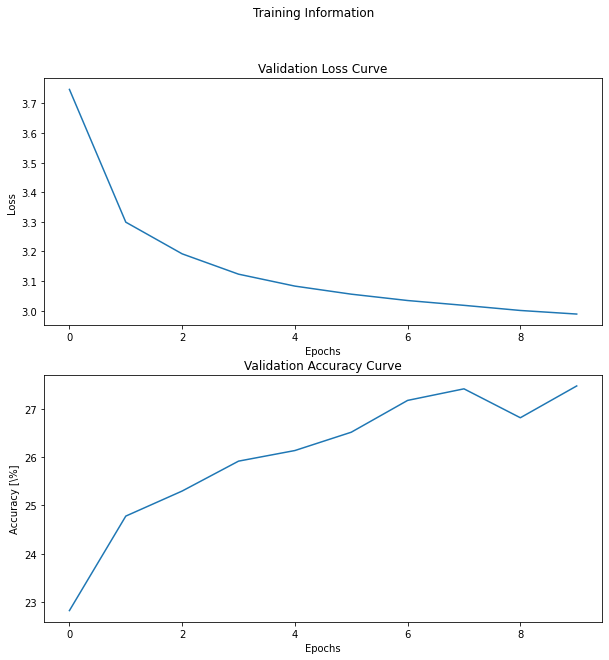

In [58]:
def plot_training_info(losses, accuracies):
  epochs = np.arange(len(losses))

  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))
  fig.suptitle("Training Information")
  ax1.set_title("Validation Loss Curve")
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")
  ax2.set_title("Validation Accuracy Curve")
  ax2.set_xlabel("Epochs")
  ax2.set_ylabel("Accuracy [\%]")
  ax1.plot(epochs, losses)
  ax2.plot(epochs, accuracies)

trained_model, losses, accuracies = train_model(model, dataLoaders, criterion, optimizer, device, num_epochs = epochs)
plot_training_info(losses, accuracies)

With our model now trained, we evaluate it on our testing dataset.

In [59]:
test_accuracy = evaluate_model(trained_model, dataLoaders["test"], device)
print(f"Obtained Test Accuracy: {test_accuracy}")

Obtained Test Accuracy: 27.82
